In [1]:
# Do not modify
from os import listdir, system
from sys import argv
from tqdm.notebook import tqdm

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize
import matplotlib.cm as cm

from astropy.cosmology import FlatLambdaCDM, WMAP7
import astropy.units as u

from modules.spline import *
from modules.stats import *
from modules.helper_functions import *

import __main__

In [2]:
executed_as_python = hasattr(__main__, '__file__')

if executed_as_python:
    matplotlib.use('Agg')


In [3]:
# Insert Elvis directory here
elvis_iso_dir = "../../../Project/Elvis/IsolatedTrees"

# Insert suite name here
suite_name = "iHall"

if executed_as_python:
    suite_name = argv[1]

In [4]:
# Do not modify
data = read_elvis_tracks(elvis_iso_dir, suite_name,varnames = ['Mvir','scale','X','Y','Z','ID','pID','upID','Rvir','Vx','Vy','Vz'])


0it [00:00, ?it/s]

In [5]:
plot_pretty()

In [6]:
num_halos = get_num_halos(data)
num_time = get_num_time(data)

In [7]:
# related quantities related to the main halo
non_zero_index, lookback_time, X_0, Y_0, Z_0, Vx_0, Vy_0, Vz_0, _, Rvir_0, coefs_X_0, coefs_Y_0, coefs_Z_0, coefs_Rvir_0, coefs_Mvir_0 = extract_elvis_data(data,0)


In [8]:
# array of pos and vec in angular coordinates
arr_ang_pos_acc = []
arr_ang_vec_acc = []

arr_ang_pos_cur = []
arr_ang_vec_cur = []

# array of pos and vec in cartesian coordinates
arr_pos_acc = []
arr_vec_acc = []

arr_pos_cur = []
arr_vec_cur = []

arr_pos_cur_dis = []
arr_vec_cur_dis = []



# array of accretion time and accretion mass
arr_time = []
arr_mass_acc = []
arr_mass_cur = []

# array row of halos that 

arr_row = []

In [9]:
# iterate over subhalos
for i in range(1, num_halos):
    state = True
    start_index = -1
    #iterate over time steps in which the main halo exists
    for j in range(non_zero_index-1, -1, -1):
        # exclude time steps where the subhalo does not exist i.e. M_subhalo = 0
        if state and data['Mvir'][i][j] > 0:
            start_index = non_zero_index-1-j
            state = False
        # filters out the subhalos that are in another halo at the time of accretion
        if not state and data['pID'][i][j] == data['ID'][0][j] and data['Mvir'][i].max()>5e8:
            # preparing the indexes for technical reasons (since the host and subhalo come into existence at different time)
            temp_index_1 = non_zero_index-1-j-start_index
            temp_index_0 = non_zero_index-1-j
            # extract the halo data
            _, lookback_time_1, X_1, Y_1, Z_1, Vx_1, Vy_1, Vz_1, halo_mvir_1, _, coefs_X_1, coefs_Y_1, coefs_Z_1, _, coefs_Mvir_1 = extract_elvis_data(data,i)
            
            # find the time interval at which the subhalo is inside at the virial radius at one end and outside at the other
            l = 0
            while l < temp_index_1 and (X_0[temp_index_0-l]-X_1[temp_index_1-l])**2+(Y_0[temp_index_0-l]-Y_1[temp_index_1-l])**2+(Z_0[temp_index_0-l]-Z_1[temp_index_1-l])**2<=Rvir_0[temp_index_0-l]**2:
                l += 1
            if l == temp_index_1:
                break
            
            
            
            index_0 = temp_index_0-l
            index_1 = temp_index_1-l
            
            # length of the time interval
            diff_time = lookback_time[index_0+1] - lookback_time[index_0]
            # spline coefficients of the host halo's trajectory at the time interval
            coef_X_0 = coefs_X_0[:,index_0]
            coef_Y_0 = coefs_Y_0[:,index_0]
            coef_Z_0 = coefs_Z_0[:,index_0]
            # spline coefficients of the virial radius of the host at the time interval
            coef_Rvir_0 = coefs_Rvir_0[:,index_0]
            
            # spline coefficients of subhalo's trajectory at the time interval
            coef_X_1 = coefs_X_1[:,index_1]
            coef_Y_1 = coefs_Y_1[:,index_1]
            coef_Z_1 = coefs_Z_1[:,index_1]
            
            # differences of spline coefficients
            diff_X = coef_X_0 - coef_X_1
            diff_Y = coef_Y_0 - coef_Y_1
            diff_Z = coef_Z_0 - coef_Z_1
            t = solve(diff_time, diff_X, diff_Y, diff_Z, coef_Rvir_0, stol = 10e-10)
            if t > 0:
                if t > diff_time:
                    break
                t += lookback_time[index_0]
                # relative position of subhalo in the host frame at accretion
                x = eval_new_spline(t, lookback_time_1, *coefs_X_1) - eval_new_spline(t, lookback_time, *coefs_X_0)
                y = eval_new_spline(t, lookback_time_1, *coefs_Y_1) - eval_new_spline(t, lookback_time, *coefs_Y_0)
                z = eval_new_spline(t, lookback_time_1, *coefs_Z_1) - eval_new_spline(t, lookback_time, *coefs_Z_0)
                # relative velocity of subhalo in the host frame at accretion
                vx = eval_der_new_spline(t, lookback_time_1, *coefs_X_1[1:]) - eval_der_new_spline(t, lookback_time, *coefs_X_0[1:])
                vy = eval_der_new_spline(t, lookback_time_1, *coefs_Y_1[1:]) - eval_der_new_spline(t, lookback_time, *coefs_Y_0[1:])
                vz = eval_der_new_spline(t, lookback_time_1, *coefs_Z_1[1:]) - eval_der_new_spline(t, lookback_time, *coefs_Z_0[1:])
                
                # current mass
                
                m = eval_spline(t, lookback_time_1, *coefs_Mvir_1)
                
                # adding to the arrays the pos/vec in angular, cartesian coordinates
                arr_row.append(i)
                arr_time.append(t)
                arr_mass_acc.append(m)
                arr_mass_cur.append(halo_mvir_1[-1])
                
                arr_ang_pos_acc.append(to_spherical(x,y,z))
                arr_ang_vec_acc.append(to_spherical(vx, vy, vz))
                arr_ang_pos_cur.append(to_spherical(X_1[-1]-X_0[-1], Y_1[-1]-Y_0[-1], Z_1[-1]-Z_0[-1]))
                arr_ang_vec_cur.append(to_spherical(Vx_1[-1]-Vx_0[-1], Vy_1[-1]-Vy_0[-1], Vz_1[-1]-Vz_0[-1]))
                
                arr_pos_acc.append(to_direction(x,y,z))
                arr_vec_acc.append(to_direction(vx,vy,vz))
                arr_pos_cur.append(to_direction(X_1[-1]-X_0[-1], Y_1[-1]-Y_0[-1], Z_1[-1]-Z_0[-1]))
                arr_vec_cur.append(to_direction(Vx_1[-1]-Vx_0[-1], Vy_1[-1]-Vy_0[-1], Vz_1[-1]-Vz_0[-1]))
                
                arr_pos_cur_dis.append([X_1[-1]-X_0[-1], Y_1[-1]-Y_0[-1], Z_1[-1]-Z_0[-1]])
                arr_vec_cur_dis.append([Vx_1[-1]-Vx_0[-1], Vy_1[-1]-Vy_0[-1], Vz_1[-1]-Vz_0[-1]])
        
            break

In [10]:
arr_pos_acc = np.array(arr_pos_acc)
arr_vec_acc = np.array(arr_vec_acc)
arr_ang_pos_acc = np.array(arr_ang_pos_acc)
arr_ang_vec_acc = np.array(arr_ang_vec_acc)

arr_pos_cur = np.array(arr_pos_cur)
arr_vec_cur = np.array(arr_vec_cur)
arr_ang_pos_cur = np.array(arr_ang_pos_cur)
arr_ang_vec_cur = np.array(arr_ang_vec_cur)

arr_mass_acc = np.array(arr_mass_acc)
arr_mass_cur = np.array(arr_mass_cur)
arr_time = np.array(arr_time)

arr_pos_cur_dis = np.array(arr_pos_cur_dis)
arr_vec_cur_dis = np.array(arr_vec_cur_dis)

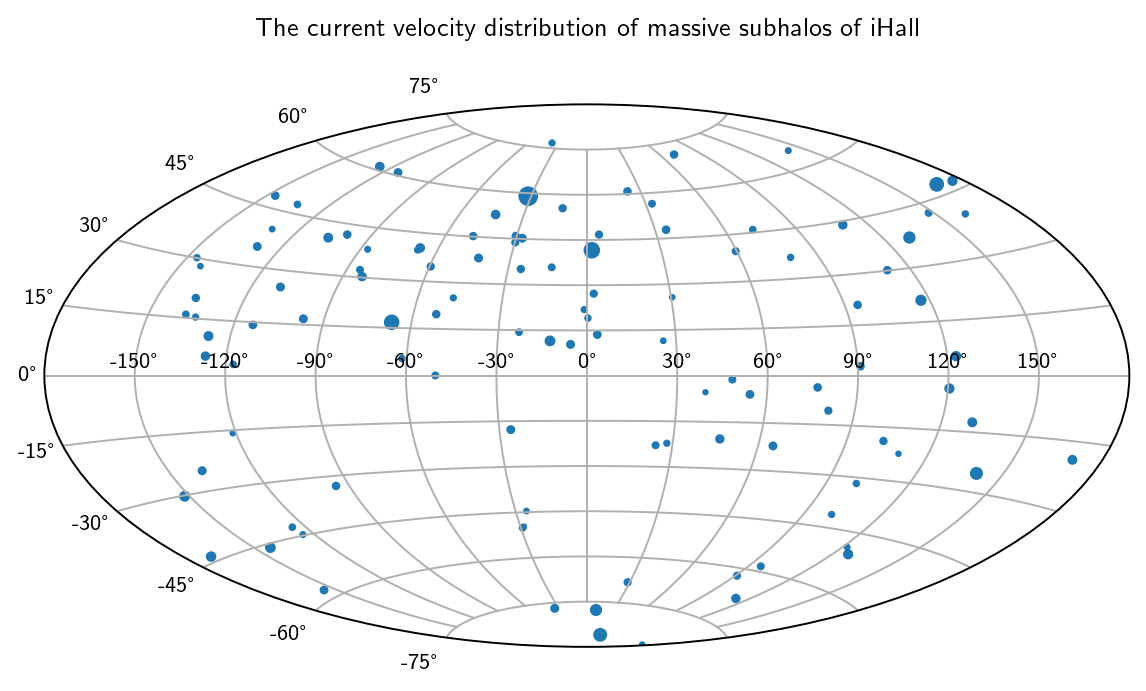

In [11]:
plt.figure(figsize=(8, 6))
plt.subplot(111, projection="aitoff")
plt.scatter(arr_ang_vec_cur[:,1], arr_ang_vec_cur[:,0], marker = '.', s = (arr_mass_cur/max(arr_mass_cur))**(2/5)*200)
plt.rcParams['axes.titley'] = 1.1
plt.title("The current velocity distribution of massive subhalos of {halo_name}".format(halo_name=suite_name))
plt.grid(True)

# if executed_as_python:
#     plt.close()
    
plt.savefig("../../result/data/{}/current_velocity_distribution_of_subhalos_of_{}.pdf".format(suite_name, suite_name))

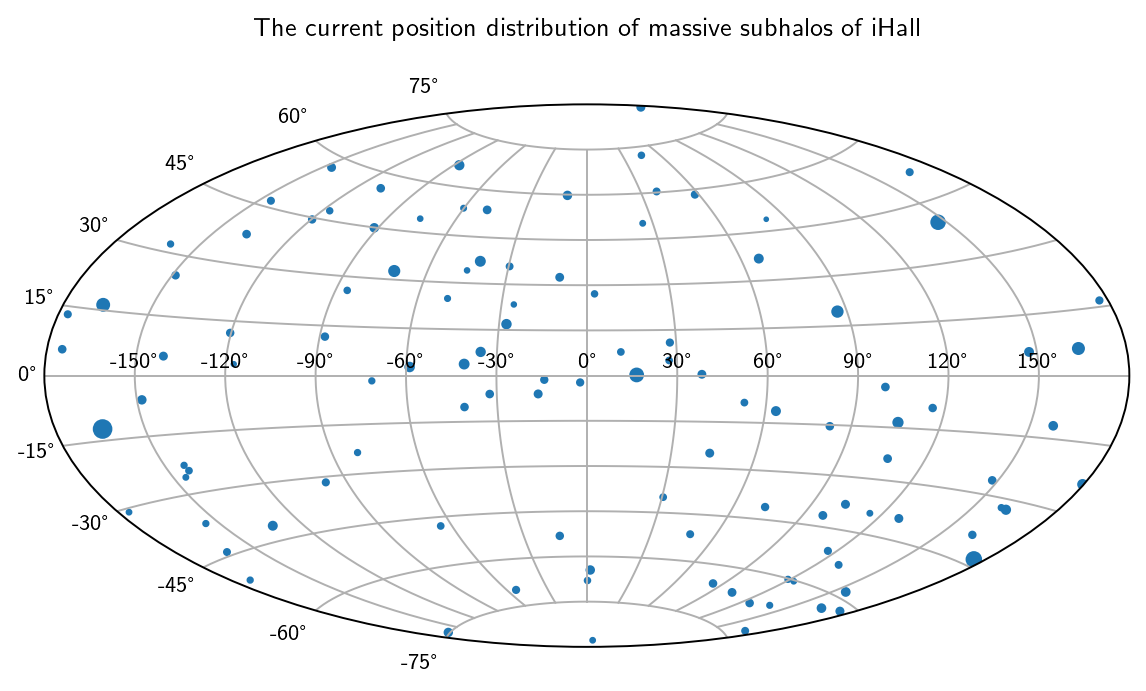

In [12]:
plt.figure(figsize=(8, 6))
plt.subplot(111, projection="aitoff")
plt.scatter(arr_ang_pos_cur[:,1], arr_ang_pos_cur[:,0], marker = '.', s = (arr_mass_cur/max(arr_mass_cur))**(2/5)*200)
plt.rcParams['axes.titley'] = 1.1
plt.title("The current position distribution of massive subhalos of {halo_name}".format(halo_name=suite_name))
plt.grid(True)

# if executed_as_python:
#     plt.close()
    
plt.savefig("../../result/data/{}/current_position_distribution_of_subhalos_of_{}.pdf".format(suite_name, suite_name))

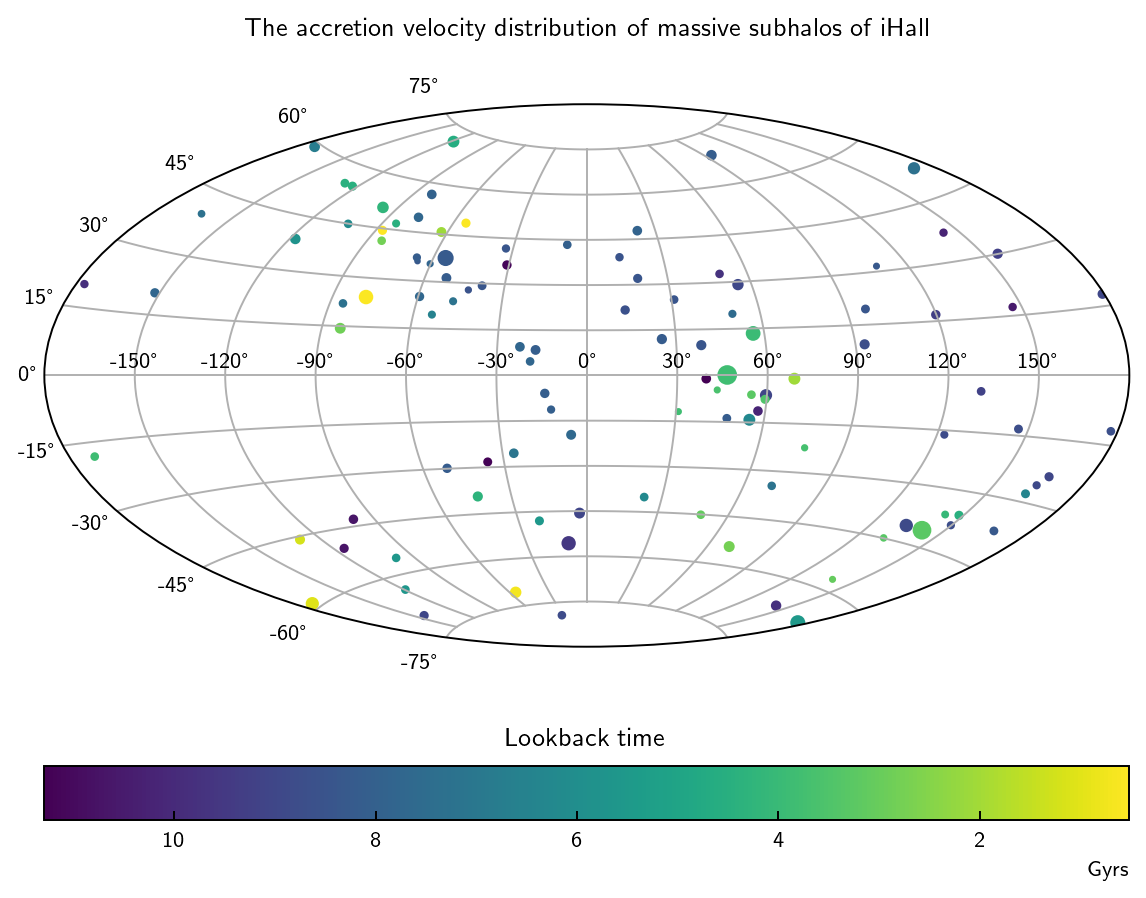

In [13]:
plt.figure(figsize=(8, 6))
plt.subplot(111, projection="aitoff")
plt.scatter(arr_ang_vec_acc[:,1], arr_ang_vec_acc[:,0], marker = '.', c=arr_time, cmap="viridis", s = (arr_mass_acc/max(arr_mass_acc))**(2/5)*200)
plt.rcParams['axes.titley'] = 1.1
plt.title("The accretion velocity distribution of massive subhalos of {halo_name}".format(halo_name=suite_name))
plt.grid(True)
clb = plt.colorbar(orientation="horizontal", ticks=[-14, -12, -10,-8,-6,-4,-2,0])
_ = clb.ax.set_title('Lookback time')
_ = clb.ax.set_xlabel('Gyrs', loc='right')
_ = clb.ax.set_xticklabels([14,12,10,8,6,4,2,0])

# if executed_as_python:
#     plt.close()
    

plt.savefig("../../result/data/{}/accretion_velocity_distribution_of_subhalos_of_{}.pdf".format(suite_name, suite_name))

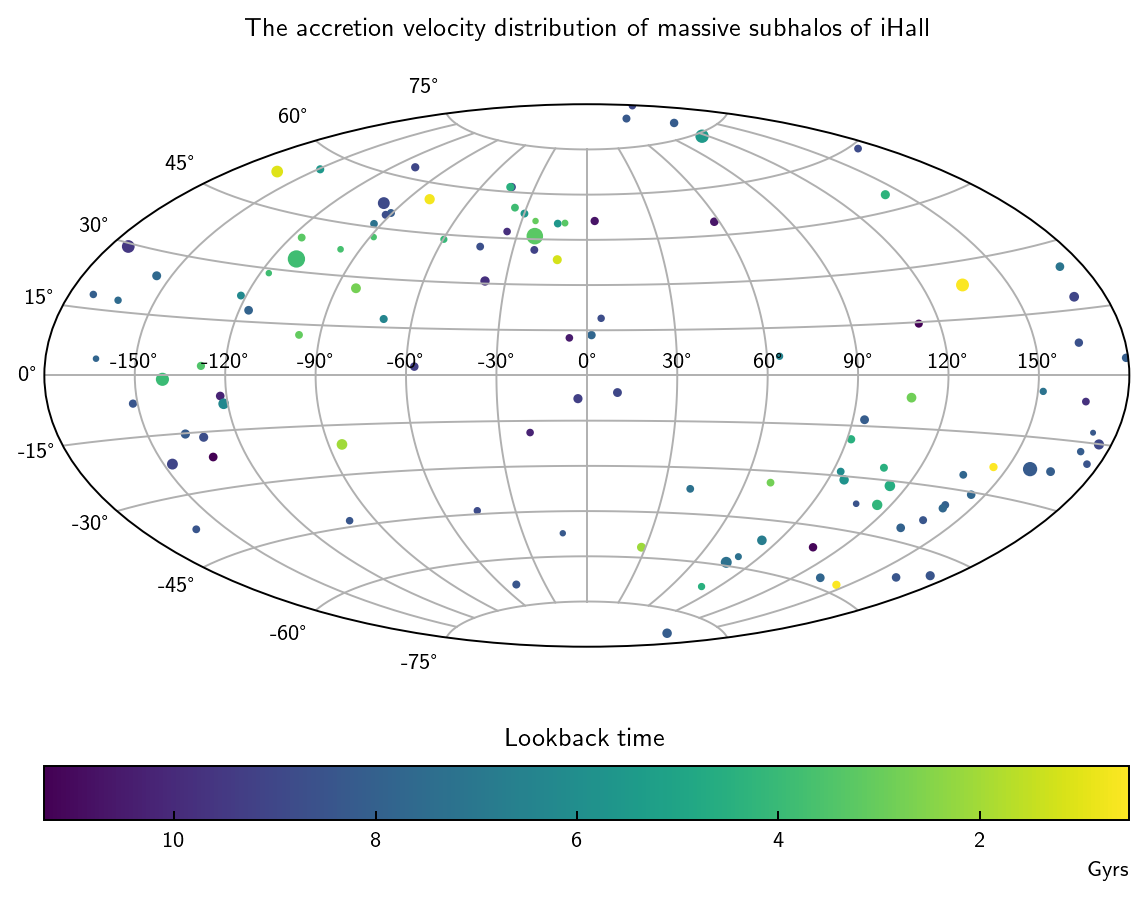

In [14]:
plt.figure(figsize=(8, 6))
plt.subplot(111, projection="aitoff")
plt.scatter(arr_ang_pos_acc[:,1], arr_ang_pos_acc[:,0], marker = '.', c=arr_time, cmap="viridis", s = (arr_mass_acc/max(arr_mass_acc))**(2/5)*150)
plt.rcParams['axes.titley'] = 1.1
plt.title("The accretion velocity distribution of massive subhalos of {halo_name}".format(halo_name=suite_name))
plt.grid(True)
clb = plt.colorbar(orientation="horizontal", ticks=[-14, -12, -10,-8,-6,-4,-2,0])
_ = clb.ax.set_title('Lookback time')
_ = clb.ax.set_xlabel('Gyrs', loc='right')
_ = clb.ax.set_xticklabels([14,12,10,8,6,4,2,0])

plt.savefig("../../result/data/{}/accretion_position_distribution_of_subhalos_of_{}.pdf".format(suite_name,suite_name))

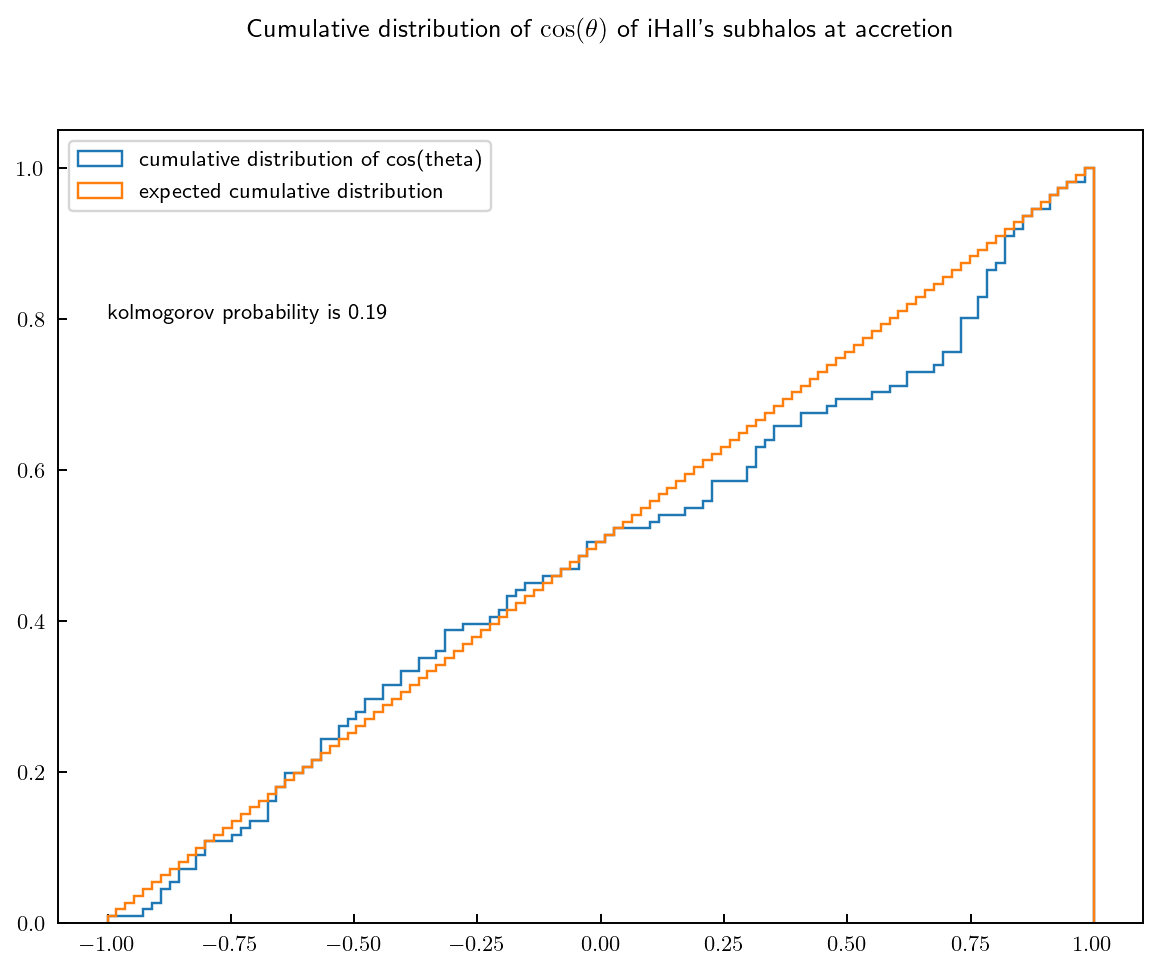

In [15]:
random_phi = np.random.rand()*2*np.pi-np.pi
random_theta = np.pi/2-np.random.rand()*np.pi

direction = np.array([-np.cos(random_theta)*np.cos(random_phi),-np.cos(random_theta)*np.sin(random_phi),np.sin(random_theta)])
dist_pos = np.sum(arr_pos_acc*direction, axis = 1)
dist_vec = np.sum(arr_vec_acc*direction, axis = 1)
n = len(dist_pos)

plt.figure(figsize=(8, 6))

_, _, _ = plt.hist(dist_pos, bins = n, range=(-1,1), density = True, cumulative=True, histtype='step', label = 'cumulative distribution of cos(theta)')
uniform = (2*np.arange(1, n+1)-n-1)/(n-1)
_, _, _ = plt.hist(uniform, bins=len(uniform), density = True, cumulative=True, histtype='step', label = 'expected cumulative distribution')
plt.title("Cumulative distribution of $\cos(\\theta)$ of {}'s subhalos at accretion".format(suite_name))
plt.rcParams['axes.titley'] = 1
plt.legend(loc='upper left')
plt.text(-1, 0.8, "kolmogorov probability is {:.2g}".format(ks_uniformity_test(dist_pos)))

# if executed_as_python:
#     plt.close()
plt.savefig("../../result/data/{}/cumulative_angular_distribution_of_{}.pdf".format(suite_name,suite_name))

<IPython.core.display.Javascript object>


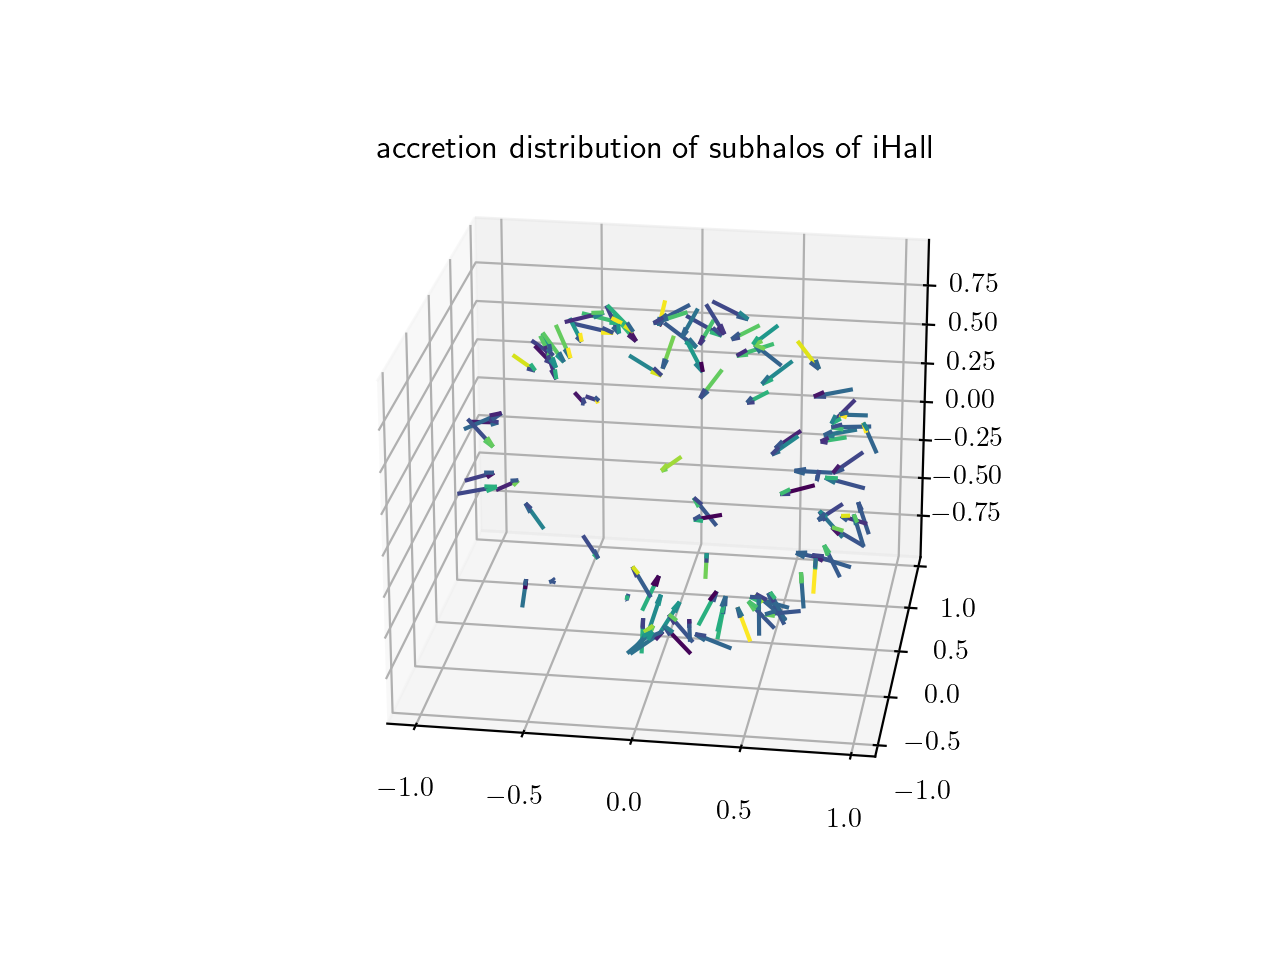

In [21]:
if not executed_as_python:
    plt.close()
    %matplotlib notebook
    ax = plt.figure().add_subplot(projection='3d')

    reshape_arr_pos_acc = arr_pos_acc.T
    reshape_arr_vec_acc = arr_vec_acc.T

    x = reshape_arr_pos_acc[0][0:100]
    y = reshape_arr_pos_acc[1][0:100]
    z = reshape_arr_pos_acc[2][0:100]
    u = reshape_arr_vec_acc[0][0:100]
    v = reshape_arr_vec_acc[1][0:100]
    w = reshape_arr_vec_acc[2][0:100]
    
    c = arr_time
    c = (c.ravel() - c.min()) / c.ptp()
    # Repeat for each body line and two head lines
    c = np.concatenate((c, np.repeat(c, 2)))
    # Colormap
    c = plt.cm.viridis(c)
    
    

    ax.quiver(x, y, z, u, v, w, length=0.2, colors=c)
    ax.set_title('accretion distribution of subhalos of {suite_name}'.format(suite_name=suite_name))
    

    plt.show()

<IPython.core.display.Javascript object>


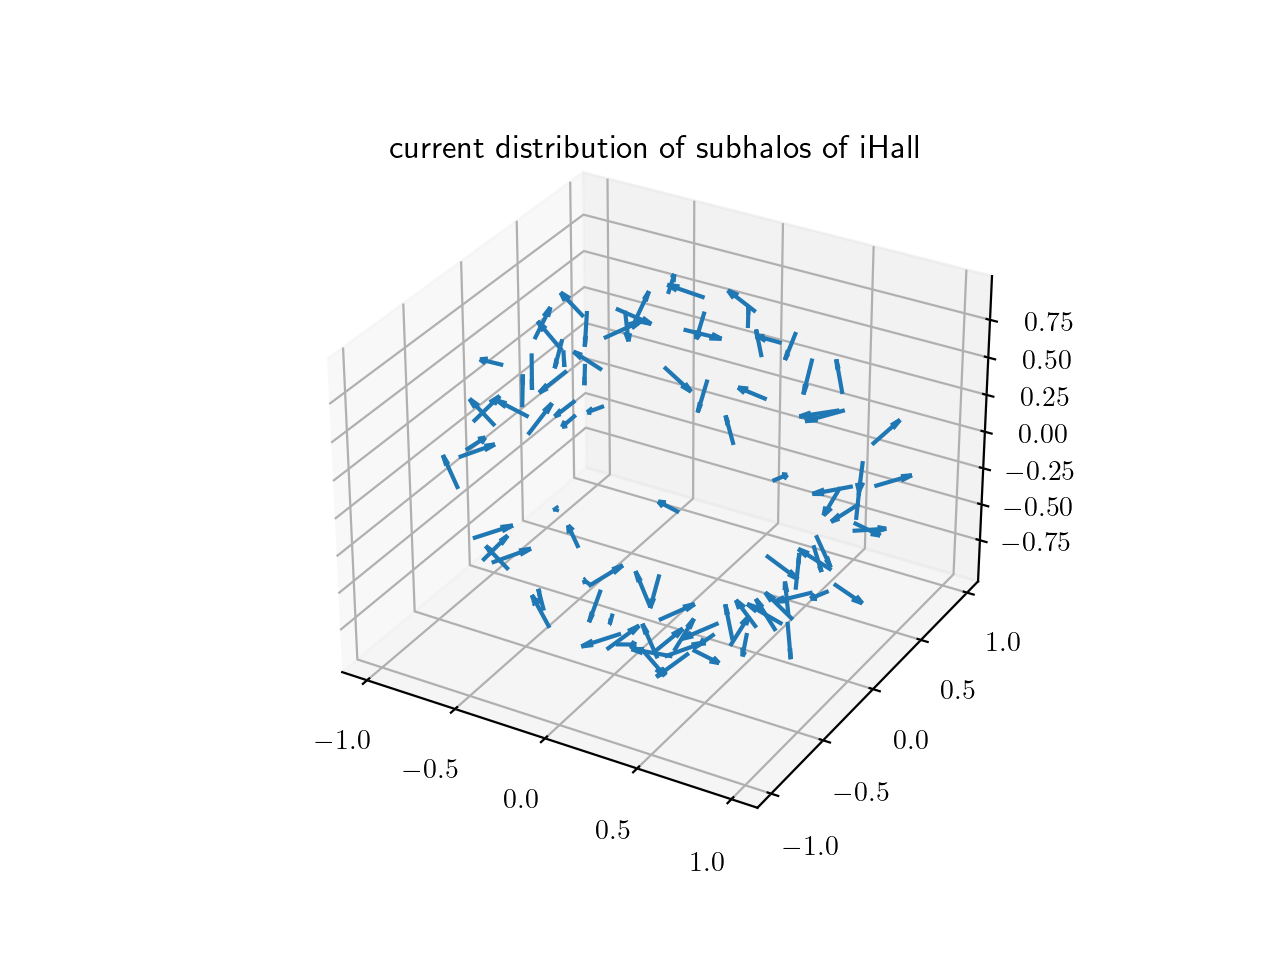

In [22]:
if not executed_as_python:
    plt.close()
    %matplotlib notebook
    ax = plt.figure().add_subplot(projection='3d')

    reshape_arr_pos_cur = arr_pos_cur.T
    reshape_arr_vec_cur = arr_vec_cur.T

    x = reshape_arr_pos_cur[0][0:100]
    y = reshape_arr_pos_cur[1][0:100]
    z = reshape_arr_pos_cur[2][0:100]
    u = reshape_arr_vec_cur[0][0:100]
    v = reshape_arr_vec_cur[1][0:100]
    w = reshape_arr_vec_cur[2][0:100]
    
#     c = arr_time
#     c = (c.ravel() - c.min()) / c.ptp()
#     # Repeat for each body line and two head lines
#     c = np.concatenate((c, np.repeat(c, 2)))
#     # Colormap
#     c = plt.cm.viridis(c)
    
    

    ax.quiver(x, y, z, u, v, w, length=0.2)
    ax.set_title('current distribution of subhalos of {suite_name}'.format(suite_name=suite_name))
    

    plt.show()

<IPython.core.display.Javascript object>


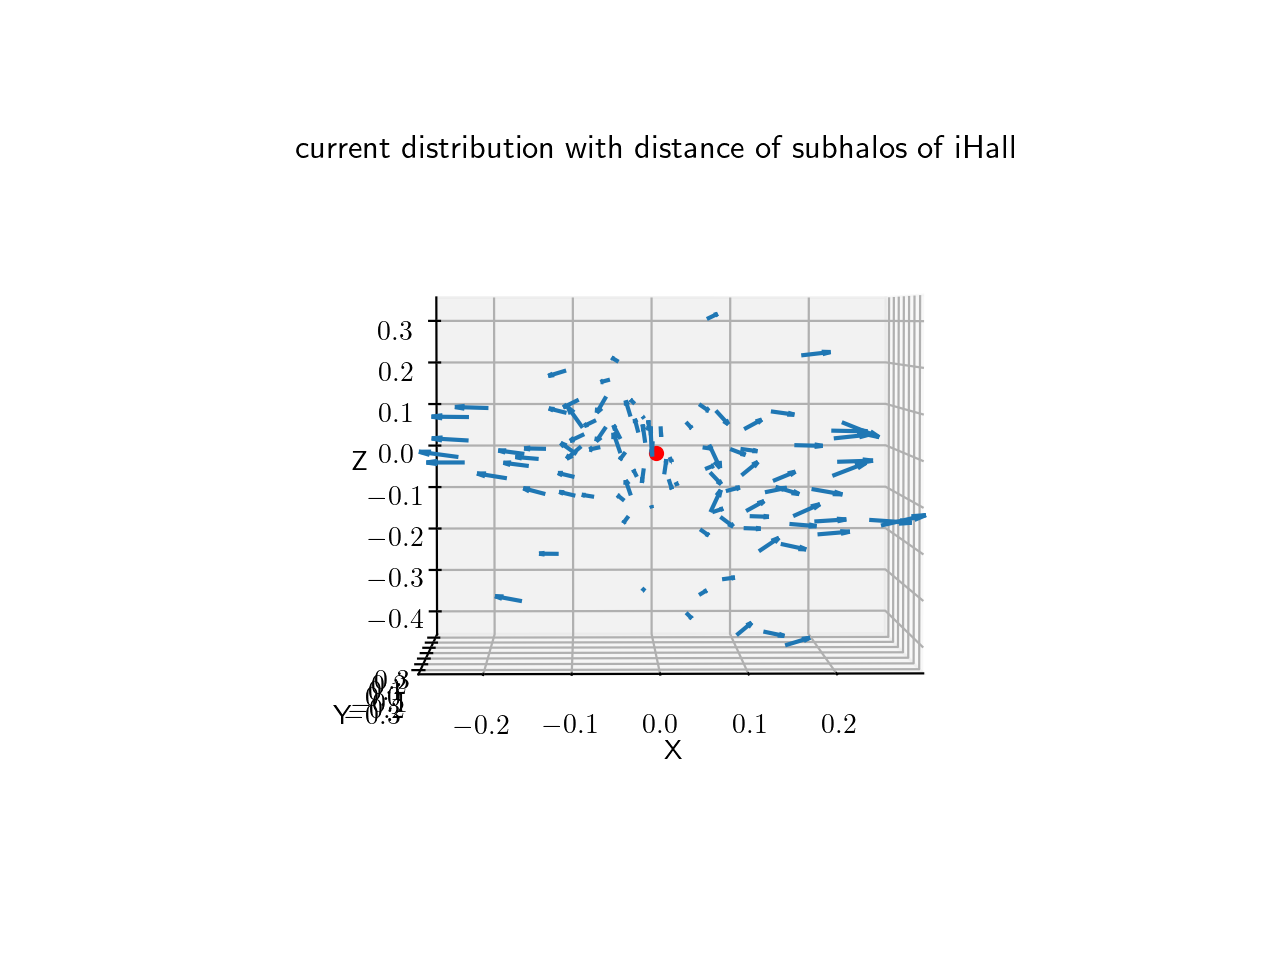

In [18]:
if not executed_as_python:
    plt.close()
    %matplotlib notebook
    ax = plt.figure().add_subplot(projection='3d')
    ax.scatter([0],[0],[0], c='red')
    reshape_arr_pos_cur_dis = arr_pos_cur_dis.T
    reshape_arr_vec_cur_dis = arr_vec_cur_dis.T

    x = reshape_arr_pos_cur_dis[0][0:100]
    y = reshape_arr_pos_cur_dis[1][0:100]
    z = reshape_arr_pos_cur_dis[2][0:100]
    u = reshape_arr_pos_cur_dis[0][0:100]
    v = reshape_arr_vec_cur_dis[1][0:100]
    w = reshape_arr_vec_cur_dis[2][0:100]
    
#     c = arr_time
#     c = (c.ravel() - c.min()) / c.ptp()
#     # Repeat for each body line and two head lines
#     c = np.concatenate((c, np.repeat(c, 2)))
#     # Colormap
#     c = plt.cm.viridis(c)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    
    ax.quiver(x, y, z, u, v, w, length=0.2)
    ax.set_title('current distribution with distance of subhalos of {suite_name}'.format(suite_name=suite_name))

    plt.show()

<IPython.core.display.Javascript object>


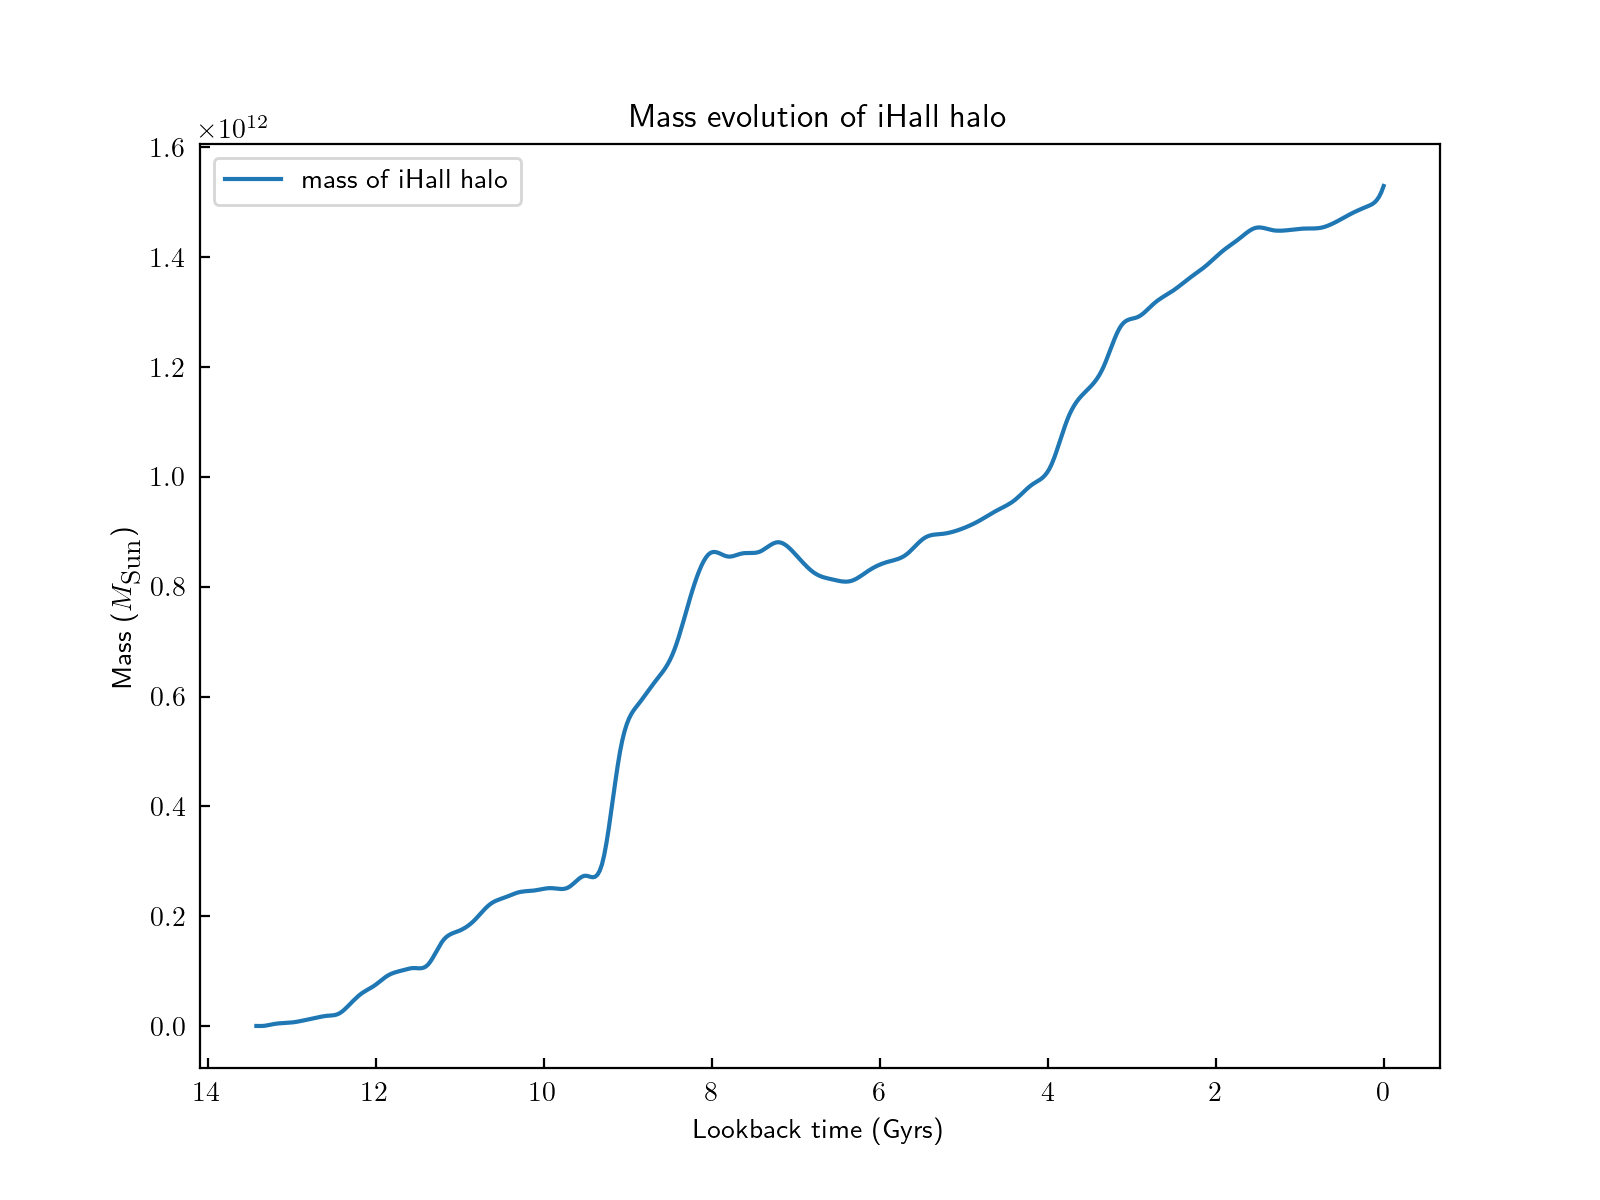

In [19]:
t_0 = min(lookback_time)
t_1 = max(lookback_time)

time_range = np.linspace(t_0, t_1, 500)
mass_range = np.array(list(map(lambda t: eval_spline(t, lookback_time, *coefs_Mvir_0), time_range)))

fig, ax = plt.subplots(figsize=(8, 6))

plt.plot(-time_range, mass_range, label="mass of {suite_name} halo".format(suite_name=suite_name))
plt.legend(loc='upper left')
ax.set_xlabel('Lookback time (Gyrs)')
ax.set_ylabel('Mass ($M_{\\textrm{Sun}}$)')
ax.set_title('Mass evolution of {suite_name} halo'.format(suite_name=suite_name))
ax.invert_xaxis()

plt.savefig("../../result/data/{}/mass_evolution_of_{}.pdf".format(suite_name,suite_name))

<IPython.core.display.Javascript object>


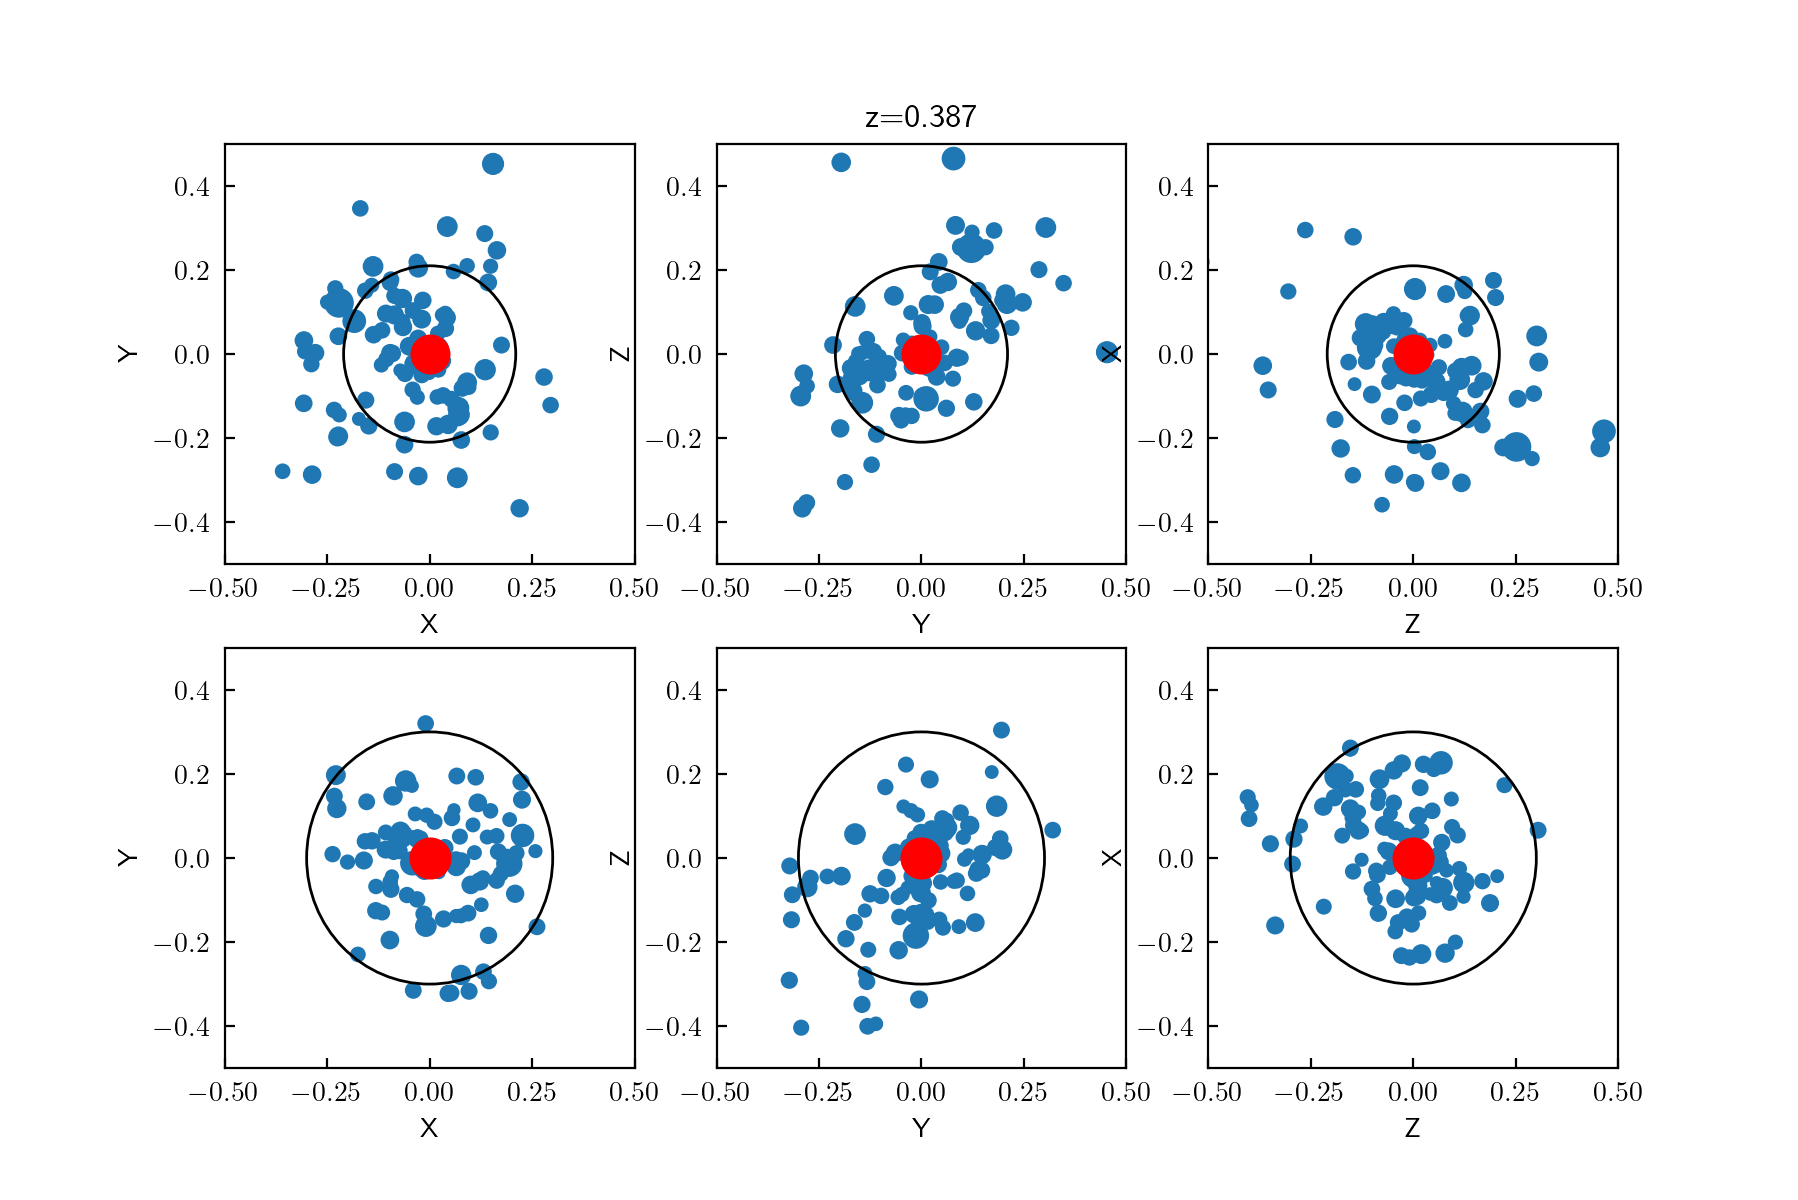

In [20]:
# name of 2D slice go here

max_mass = max(data['Mvir'][0])

fig, axs = plt.subplots(2,3)
fig.set_figheight(6)
fig.set_figwidth(9)

scats = []
scats2 = []
patches = []
planes = ['XY','YZ','ZX']

def init():
    return scats, scats2

def prep_data(i):
    mass = (np.flip(data['Mvir'], axis = 1).T)[i][[0]+arr_row][0:100]
    non_zero_index = mass > 0
    scale = (np.flip(data['scale'], axis = 1).T)[i][[0]+arr_row][0:100][non_zero_index]
    x = (np.flip(data['X'], axis = 1).T)[i][[0]+arr_row][0:100][non_zero_index]*scale
    y = (np.flip(data['Y'], axis = 1).T)[i][[0]+arr_row][0:100][non_zero_index]*scale
    z = (np.flip(data['Z'], axis = 1).T)[i][[0]+arr_row][0:100][non_zero_index]*scale
    rvir = (np.flip(data['Rvir'], axis = 1).T)[i][[0]+arr_row][0:100][non_zero_index]*scale
    mass = mass[non_zero_index]
    return mass, x, y, z, rvir, scale
    
def animate(i):
    mass, x, y, z, rvir, scale = prep_data(i)
    pos = [[x,y],[y,z],[z,x]]
    if len(scale) > 0:
        redshift = 1/scale-1        
        axs[0][1].set_title("z={:.3f}".format(redshift[0]))
        
        for j in range(3):
            scats[j].set_offsets(np.array([pos[j][0][1:]-pos[j][0][0],pos[j][1][1:]-pos[j][1][0]]).T)
            scats[j].set_sizes(200*(mass[1:]/max_mass)**(1/4))
            
            scats2[j].set_offsets(np.array([pos[j][0][:1]-pos[j][0][0],pos[j][1][:1]-pos[j][1][0]]).T)
            scats2[j].set_sizes(200*(mass[:1]/max_mass)**(1/4))
        
        for j in range(3):
            patches[j].set(radius=rvir[0]/1000, fill=False)
    else:
        for j in range(3):
            scats[j].set_offsets(np.array([[],[]]).T)
            scats2[j].set_offsets(np.array([[],[]]).T)
    return scats, scats2


mass, x, y, z, rvir, scale = prep_data(-1)
pos = [[x,y],[y,z],[z,x]]

for i in range(3):
    axs[0][i].set_xlim((-0.5,0.5))
    axs[0][i].set_ylim((-0.5,0.5))
    scats.append(axs[0][i].scatter([],[]))
    scats2.append(axs[0][i].scatter([],[], c='red'))
    patches.append(plt.Circle((0,0),20, fill=False))
    axs[0][i].add_patch(patches[i])
    
    axs[0][i].set_xlabel(planes[i][0])
    axs[0][i].set_ylabel(planes[i][1])

    axs[1][i].scatter(pos[i][0][1:]-pos[i][0][0],pos[i][1][1:]-pos[i][1][0], s=200*(mass[1:]/max_mass)**(1/4))
    axs[1][i].scatter(pos[i][0][:1]-pos[i][0][0],pos[i][1][:1]-pos[i][1][0], s=200*(mass[:1]/max_mass)**(1/4), c='red')
    
    
    axs[1][i].set_xlim((-0.5,0.5))
    axs[1][i].set_ylim((-0.5,0.5))
    axs[1][i].set_xlabel(planes[i][0])
    axs[1][i].set_ylabel(planes[i][1])
    axs[1][i].add_patch(plt.Circle((0,0),rvir[0]/1000, fill=False))

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=75, interval=200, blit=False)
    
if executed_as_python:
    plt.close()

anim.save('../../result/data/{}/accretion_animation_of_{}.gif'.format(suite_name, suite_name), writer='ffmpeg')